# loading SPN code

In [13]:
include("../src/SPN.jl")

SPN

## load test data

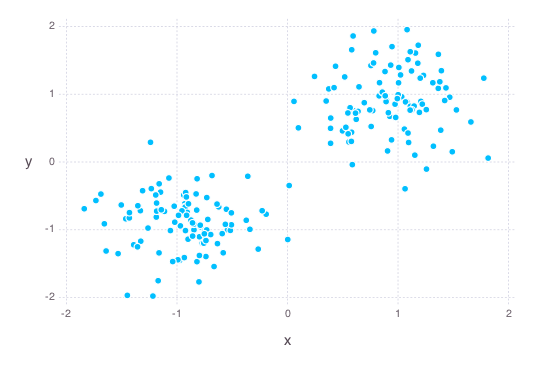

In [2]:
using Gadfly

N = 100

X1 = randn(2, N)
X2 = 5 + randn(2, N)

X = cat(2, X1, X2)

using StatsBase
X = zscore(X, 2)

plot(x = X[1,:], y = X[2,:], Geom.point)

## SPN Definition

In [3]:
# construct initial SPN
using BNP

(D, N) = size(X)

μ0 = vec( zeros(D) )
κ0 = 1.0
ν0 = convert(Float64, D)
Ψ = eye(D) * 10

G0 = GaussianWishart(μ0, κ0, ν0, Ψ);

d = deepcopy(G0)
add_data!(d, X)

# create mv node
dist = SPN.MultivariateNode{ConjugatePostDistribution}(d, collect(1:D))

# create root and add mv node
root = SPN.SumNode(0)
SPN.add!(root, dist)

# create data assignments
Z = vec(ones(Int, N))
da = SPN.DataAssignments(Z, collect(1:N))

# create Buffer Object
B = SPN.SPNBuffer(D, N, collect(1:N), X, da)

SPN.SPNBuffer(2,200,[1,2,3,4,5,6,7,8,9,10  …  191,192,193,194,195,196,197,198,199,200],2x200 Array{Float32,2}:
 -0.77124  -1.14901   -1.18722   -0.775448  …  0.058588  1.11055  0.979009
 -1.19689  -0.444825  -0.812566  -1.09651      0.894154  1.62702  0.657239,SPN.DataAssignments(1,[1,1,1,1,1,1,1,1,1,1  …  1,1,1,1,1,1,1,1,1,1],[1,2,3,4,5,6,7,8,9,10  …  191,192,193,194,195,196,197,198,199,200],SPN.DataAssignments[]))

In [4]:
function prune(Buf::SPN.SPNBuffer, node::SPN.Leaf)
    
    println("leaf")
   
    if Buf.N == 0
        return true
    else
        return false
    end
    
end

prune (generic function with 1 method)

In [5]:
function prune(Buf::SPN.SPNBuffer, node::SPN.Node)
    
    deepprune!(Buf, node)
    
    if length(node.children) == 0
        return true
    else
        return false
    end
    
end

prune (generic function with 2 methods)

In [6]:
function deepprune!(Buf::SPN.SPNBuffer, root::SPN.Node)
   
    pruneList = fill(false, Buf.Z.c)
    
    for i in 1:Buf.Z.c
        pruneList[i] = prune(Buf(i), root.children[i])
    end
    
    println("in deepprune")
    println(pruneList)
    
    for i in length(pruneList):-1:1
        if pruneList[i]
            SPN.remove!(root, i)
            # remove assignment for i -> TODO!
        end
    end
end

deepprune! (generic function with 1 method)

## pruning tests

In [14]:


N = 10
X = randn(1,N)
Z = 1 + round(Int, rand(N) .>= 0.5)

d = SPN.DataAssignments(Z, collect(1:N))

delete!(d, 2)

LoadError: LoadError: MethodError: `delete!` has no method matching delete!(::SPN.DataAssignments, ::Int64)
Closest candidates are:
  delete!(!Matched::IntSet, ::Integer)
  delete!(!Matched::ObjectIdDict, ::ANY)
  delete!(!Matched::Dict{K,V}, ::Any)
  ...
while loading In[14], in expression starting on line 9

In [9]:
using Distributions

X = randn(1,N)

Z = 1 + round(Int, rand(N) .>= 0.5)

root = SPN.SumNode(0)
SPN.add!(root, SPN.UnivariateNode(fit(Normal, X[:,Z .== 1])))
SPN.add!(root, SPN.UnivariateNode(fit(Normal, X[:,Z .== 2])))
SPN.normalize!(root);

d = SPN.DataAssignments(Z, collect(1:N))

d1 = SPN.DataAssignments(ones(Int, length(d[1])), d[1])
d2 = SPN.DataAssignments(ones(Int, length(d[2])), d[2])

push!(d.children, d1)
push!(d.children, d2)

B = SPN.SPNBuffer(1, N, collect(1:N), X, d)

prune(B, root)

B(1)

leaf


SPN.SPNBuffer(1,90,[1,2,3,4,5,6,7,8,9,10  …  81,82,83,84,85,86,87,88,89,90],1x90 SubArray{Float32,2,Array{Float32,2},Tuple{Colon,Array{Int64,1}},1}:
 -0.966708  2.02533  1.23429  0.769849  …  -0.0771924  -0.405739  2.45505,SPN.DataAssignments(1,[1,1,1,1,1,1,1,1,1,1  …  1,1,1,1,1,1,1,1,1,1],[2,5,6,9,11,12,14,17,21,25  …  183,186,189,190,193,194,195,196,199,200],SPN.DataAssignments[]))

leaf
in deepprune
Bool[false,false]


max value: 1
SPN.SumNode(0,SPN.SPNNode[SPN.MultivariateNode{BNP.ConjugatePostDistribution}(BNP.GaussianWishart(2,200,[-6.439293542825908e-14,2.398081733190338e-14],[198

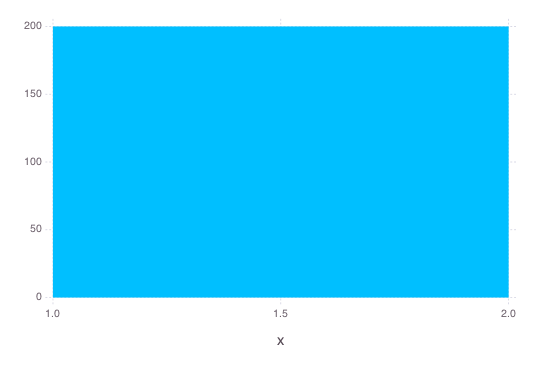

.99999999999994 172.2806236289588
 172.2806236289588 198.9999999999999],[0.0,0.0],1.0,2.0,[10.0 0.0
 0.0 10.0]),[1,2])],Float32[0.911995f0],0)


In [5]:
α = 1.0

"Sum Node SPN extension."
#function cgibbs_crp!(B::DPMBuffer)

    # randomize data
    shuffle!(B.idx)

    z = -1
    k = -1
    K = B.Z.c

    p = ones(K + 1) * -Inf

    for index in B.idx

        x = B.X[:, index]

        # get assignment
        z = B.Z(index)

        # remove sample from cluster
        SPN.deepremove_data!(root.children[z], x)

        # remove cluster assignment
        z = -1

        # compute posterior predictive
        for i in 1:K

            llh = SPN.llh(root.children[i], x)[1]
            crp = log( length(B.Z[i]) / B.N + α - 1 )

            p[i] = llh + crp
        end

        p[K + 1] = logpred(G0, x) + log( α / (B.N + α - 1) )
        p = exp(p - maximum(p))

        k = rand_indices(p)

        if k > K
            # add new cluster

            d = deepcopy(G0)
            add_data!(d, x)

            # create mv node
            SPN.add!(root, SPN.MultivariateNode{ConjugatePostDistribution}(d, collect(1:D)) )

            B.Z.c += 1
            K = B.Z.c
            p = ones(K + 1) * -Inf

        else
            # add to cluster
            SPN.deepadd_data!(root.children[k], x)
        end

        B.Z.Z[index] = k
    end

    # prune this and all child nodes if necessary
    if prune(B, root)
        # this node can be removed

    end


println("max value: ", maximum(B.Z.Z))
println(root)
plot(x = B.Z.Z, Geom.histogram)